In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL

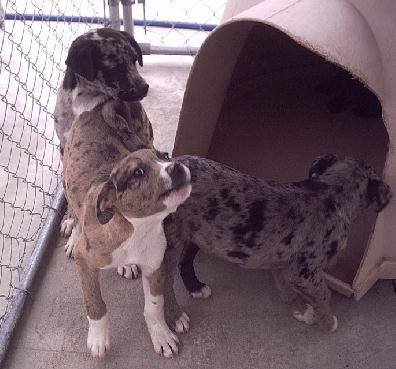

In [3]:
PATH = 'data/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Explore data
train_dir = pathlib.Path(train_dir)
dogs_train = list(train_dir.glob('dogs/*'))
PIL.Image.open(str(dogs_train[1]))

In [19]:
!mkdir data/cats_and_dogs/test/data
!mv data/cats_and_dogs/test/* data/cats_and_dogs/test/data

from IPython.display import clear_output
clear_output()

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=32, 
    directory=train_dir,
    target_size=(150, 150),
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=32, 
    directory=validation_dir,
    target_size=(150, 150),
    class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=32, 
    directory=test_dir,
    target_size=(150, 150),
    class_mode=None,
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
